In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scipy

Requirement already up-to-date: scipy in /opt/conda/lib/python3.7/site-packages (1.5.3)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-image

Requirement already up-to-date: scikit-image in /opt/conda/lib/python3.7/site-packages (0.17.2)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import time
import math
import numpy as np
import random
import pywt
import cv2
from scipy import fftpack
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet
from skimage.restoration import estimate_sigma
from skimage.restoration import denoise_tv_chambolle
from skimage.restoration import denoise_wavelet
import scipy as sp


In [5]:
#read image
img = cv2.imread('brain1.jpeg',0)
#go to the k-space of the image
center = np.fft.fftshift(np.fft.fft2(img,norm='ortho'))

To get an undersampled k-space any of the functions bellow can be used. The input parameters are the image, that is to be undersampled, the percentage of points one wants (for the functions mixed and rectangle percentage refers to the size of the percentage of lines around the middle from total lines/ lenth of the size of the square as percentage of the total lenth, as well as percentage of lines that follow the gaussian distributions that are to be taken as well/percentage of points from the total points to be selected based on the gaussian distribution, a line/point can be selected by both selection figures so the persentage of total points varies) and the seed for the random number generator (default is set to 5). An example will be given using the _randomgauss_ function.

In [6]:
"""for all functions (percentage is a bit different for mixed and rectangle):
    Imput:
    x - image you want a sampling pattern for
    percentage -persentage of taken points (for all functions except mixed and rectangle)
    seed -seed for the radom number generator
    Output:
    b - sampling pattern
    """
def uniformrandom( x, percentage,seed=5):
    rng = np.random.default_rng(seed = seed)
    a = []
    for i in range(math.floor(percentage*x.shape[0]*x.shape[1])):
        a.append([rng.integers(low=0,high=x.shape[0]), rng.integers(low=0,high=x.shape[1])])  #33% of the total data
    
    b = np.zeros((x.shape), dtype = int)
    
    for (i,j) in a:
        b[i,j] = 1
        
    b = b.astype(bool).astype(int)
    return b

def randomline( x, percentage,seed=5):
    rng = np.random.default_rng(seed = seed)
    a = rng.integers(low=0,high=x.shape[1]-1, size= (math.floor(percentage*x.shape[1])))
    b = np.zeros((x.shape), dtype = np.int)
    
    for j in a:
        b[:,j] = 1

    
    return b

def randomgauss( x, percentage,seed=5):
        
    rng = np.random.default_rng(seed = seed)    
    mu0, sigma0 = math.floor(0.5*x.shape[0]), math.floor(0.1*x.shape[0])
    mu1, sigma1 = math.floor(0.5*x.shape[1]), math.floor(0.1*x.shape[1])
    a = []
    for i in range(math.floor(percentage*x.shape[0]*x.shape[1])):
        a.append([rng.normal(mu0,sigma0), rng.normal(mu1,sigma1)])
    
    a = np.array(a, dtype=np.int)

    b = np.zeros((x.shape), dtype = np.int_)
    
    for (i,j) in a:
        b[i,j] = 1

    return b

def randombinomial( x, percentage,seed=5):
    rng = np.random.default_rng(seed = seed)
    n0, p0 = x.shape[0], .5
    n1,p1 = x.shape[1], .5
    
    a = []
    for i in range(math.floor(percentage*x.shape[0]*x.shape[1])):
        a.append([rng.binomial(n0,p0), (rng.binomial(n1,p1))])

    b = np.zeros((x.shape), dtype = np.int)
    
    for (i,j) in a:
        b[i,j] = 1
        
    return b

def randomskellam(x, percentage,seed=5):
    
    np.random.seed(seed)
    from scipy.stats import skellam
    mu01, mu02 = math.floor(0.5*x.shape[0]), .5
    mu11, mu12 = math.floor(0.5*x.shape[1]), .5
    
    a = []
    for i in range(math.floor(percentage*x.shape[0]*x.shape[1])):
        a.append([skellam.rvs(mu01,mu02), skellam.rvs(mu11,mu12)])
    
    a = np.array(a, dtype=np.int)
    b = np.zeros((x.shape), dtype = np.int)
    
    for (i,j) in a:
        b[i,j] = 1

    return b

def gaussline( x, percentage,seed=5):
    
    rng = np.random.default_rng(seed = seed)
    mu, sigma = math.floor(0.5*x.shape[1]), math.floor(0.15*x.shape[1])
    s = rng.normal(mu, sigma, size = (math.floor(percentage*x.shape[1])))
    s = s.round().astype(int)
    true_list=[]
    max_allowed = max(x.shape)-1
    for item in s:
        if item <= max_allowed and item >= 0 and (item not in true_list):
            true_list.append(item)
    else:
        while True:
            a = int(np.random.normal(mu, sigma))
            if a <= max_allowed and a >= 0 and (a not in true_list):
                true_list.append(a)
                break
    b = np.zeros((x.shape), dtype = np.int)
    
    for j in true_list:
        b[:,j] =1

    return b

def mixed(x, percentage,seed=5):
    rng = np.random.default_rng(seed = seed)
    b = np.zeros((x.shape), dtype = np.int)
    
    for j in range(math.floor(x.shape[1]*(0.5-percentage/2)), math.floor(x.shape[1]*(0.5+percentage/2))):
        b[:,j]= 1
    
    mu, sigma = math.floor(0.5*x.shape[1]), math.floor(0.15*x.shape[1])
    s = rng.normal(mu, sigma, size = (math.floor(percentage*x.shape[1])))
    s = s.round().astype(int)
    true_list=[]
    max_allowed = max(x.shape)-1
    for item in s:
        if item <= max_allowed and item >= 0 and (item not in true_list):
            true_list.append(item)
    else:
        while True:
            a = int(np.random.normal(mu, sigma))
            if a <= max_allowed and a >= 0 and (a not in true_list):
                true_list.append(a)
                break
    
    for j in true_list:
        b[:,j] =1
    
    return b

def rectangle( x, proportion,seed=5):   #Proportion = size of rectangle, #Percentage = wrt normal distribution
    rng = np.random.default_rng(seed = seed)
    b = np.zeros((x.shape), dtype = np.int)
    
    mu0, sigma0 = math.floor(0.5*x.shape[0]), math.floor(0.1*x.shape[0])
    mu1, sigma1 = math.floor(0.5*x.shape[1]), math.floor(0.1*x.shape[1])
    a = []
    for i in range(math.floor(proportion*x.shape[0]*x.shape[1])):
        a.append([rng.normal(mu0,sigma0), rng.normal(mu1,sigma1)])
    
    a = np.array(a, dtype=np.int)
    
    for (i,j) in a:
        b[i,j] = 1
    
    for j in range(math.floor(x.shape[1]*0.5*(1-proportion)), math.floor(x.shape[1]*(1-.5*(1-proportion)))):
         for i in range(math.floor(x.shape[0]*.5*(1-proportion)), math.floor(x.shape[0]*(1-.5*(1-proportion)))):
                b[i,j] = 1
    return b 

In [7]:
randomgauss_ = randomgauss(center, .125,seed=10)

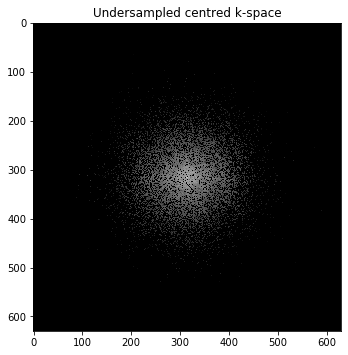

In [8]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(center*randomgauss_)), "gray"), plt.title("Undersampled centred k-space")
plt.show()

In order to compute the spr and tspr of a sampling pattern one can use the functions _spr_ and _tspr_. The only imput they require is the sampling pattern and the output is the spr/tspr respectively. An example is given on a  64x64 sampling pattern created with the function _randomline_.

In [9]:

def re_sparce(x,slices):
    coeffs_processed = pywt.array_to_coeffs(x,slices,output_format='wavedec2')
    return pywt.waverec2(coeffs_processed,"db5",mode="periodization")

def apply_Sp(x,lv=None):
    C =pywt.wavedec2(x,"db5",mode="periodization",level = lv)
    return pywt.coeffs_to_array(C)[0]

def apply_Fu(sampling_pattern, x):
    # compute subsampled FFT
    return sampling_pattern*np.fft.fftshift(np.fft.fft2(x,norm="ortho"))

def apply_Fu_adjoint(sampling_pattern, y):
    return np.fft.ifft2(np.fft.ifftshift(sampling_pattern*y),norm="ortho")
     

def spr(sampling_pattern):
    """
    Input-Sampling pattern
    Output-Spr value of the sampling pattern
    """
    maxima = np.zeros(sampling_pattern.shape,dtype = np.complex)
    for x in range(sampling_pattern.shape[0]):
        for y in range(sampling_pattern.shape[1]):
            # in this iteration, the index "i" corresponds to the gridpoint (x, y)

            # construct basis vector
            e_i = np.zeros(sampling_pattern.shape,dtype = np.complex)
            e_i[x, y] = 1

            # compute psf_i = Fu* Fu e_i
            # psf_i[xx, yy] is PSF(i,j) if index "j" corresponds to gridpoint (xx, yy)
            psf_i = apply_Fu_adjoint(sampling_pattern, apply_Fu(sampling_pattern, e_i))

            # normalize; psf_i[x, y] is PSF(i,i)
            psf_i = np.abs(psf_i / psf_i[x, y])

            # trick to exclude point "i" itself from maximum: set it to -infinity
            psf_i[x, y] = -np.inf

            # "inner" maximum, over "j"
            maxima[x, y] = np.max(psf_i)
    spr = np.max(maxima)
    return abs(spr)
 

def tspr(sampling_pattern,lvl=None):
    """
    Input:
    Sampling pattern
    Level - level of the used wavelet transform
    Output-Spr value of the sampling pattern
    """
    # gridsize should be 2-element tuple, e.g. gridsize = (10, 10)
    #level specifies the level of the wavelet transform
    
    #extract the shape of the used wavelet transform so that a point can be brought back from wavelet to image space
    C =pywt.wavedec2(sampling_pattern,"db5",mode="periodization",level=lvl)
    coeff_slices = pywt.coeffs_to_array(C,padding=0)[1]
    
    maxima = np.zeros(sampling_pattern.shape,dtype = np.complex)
    for x in range(sampling_pattern.shape[0]):
        for y in range(sampling_pattern.shape[1]):
            # in this iteration, the index "i" corresponds to the gridpoint (x, y)

            # construct basis vector
            e_i = np.zeros(sampling_pattern.shape,dtype = np.complex)
            e_i[x, y] = 1

            # compute psf_i = Fi Fu* Fu Fi* e_i
            # psf_i[xx, yy] is PSF(i,j) if index "j" corresponds to gridpoint (xx, yy)
            psf_i = apply_Sp(apply_Fu_adjoint(sampling_pattern, apply_Fu(sampling_pattern, re_sparce(e_i,coeff_slices))),lvl)

            # normalize; psf_i[x, y] is PSF(i,i)
            psf_i = np.abs(psf_i / psf_i[x, y])

            # trick to exclude point "i" itself from maximum: set it to -infinity
            psf_i[x, y] = -np.inf

            # "inner" maximum, over "j"
            maxima[x, y] = np.max(psf_i)
    tspr = np.max(maxima)
    return abs(tspr)

In [10]:
test_patern=randomgauss(np.zeros((64,64)), .125,seed=10)
print(f"tspr: {tspr(test_patern)}")
print(f"spr: {spr(test_patern)}")

tspr: 12.153418391369605
spr: 0.8164458715277837


In order to reconstruct an image based on an undersampled k-space one of the following algorithms can be used: _ista_ ,  _fista_ , _conj\_grad_ , _mfista_ , _watv_ . An example will be given using _fista_ .

In [35]:
def adjoint_fourier(x):
    """Computes the inverse fourier transform of an image"""
    return np.fft.ifft2(np.fft.ifftshift(x),norm='ortho')

def fourier(x):
    """Computes the fourier transform of an image"""
    return np.fft.fftshift(np.fft.fft2(x,norm='ortho'))

def wavelet(x):
    """
    Computes the wavelet transorm of an image
    Input: x-Image
    Output: 
    [0]-array of the wavelet coeffitients
    [1]-coeffietient slices used for the inverse wavelet transform
    """
    C =pywt.wavedec2(x,"db5",mode="periodization",level=None)
    return  pywt.coeffs_to_array(C,padding=0)

def inverse_wavelet(wavelet_coeff,coeff_slices):
    """
    Returns an image from wavelet space to image space
    Input:
    wavelet_coeff - wavelet coeffitients of an image
    coeff_slices - the slices of coeffitients
    Output: the image in wavelet spacce
    """
    coeffs_processed=pywt.array_to_coeffs(wavelet_coeff,coeff_slices,output_format='wavedec2')
    return pywt.waverec2(coeffs_processed,"db5",mode="periodization")

def objective (x,obs,pattern):
    Hx = pattern*fourier(x)
    arr_obj= wavelet(x)[0]
    return np.linalg.norm(Hx - obs)**2 + np.linalg.norm(arr_obj.ravel(), 1) 


def ista(y,pattern,regpar,alpha,Nit):
    """
    Input: 
    y - observed signal
    regpar - regrularization parameter
    alpha - need alpha >= max(eig(H'*H))
    Nit - number of iterations
    pattern - sampling pattern used

    Output:
    x - result of deconvolution
    J - objective function
    """
    x= adjoint_fourier(y) #initialize x
    #treshold parameter
    T = regpar/(2*alpha)

    for k in range(Nit):
        #Axk in (3)  
        Hx = pattern*fourier(x)
        #computation of the wavelet transform of x used for the tresholding
        arr,coeff_slices = wavelet(x)
        #2tkAT (Axk − b) in (3)
        norm2 = adjoint_fourier(y-Hx)/alpha 
        #computation of the wavelet transform of 2tkAT (Axk − b) in (3) in order to do the tresholding in wavelet space
        arr_norm2 = wavelet(norm2)[0]
        #do the tresholding in wavelet space
        x_wavelet = pywt.threshold(arr+arr_norm2, T, mode='soft')
        #return to image space
        x=inverse_wavelet(x_wavelet,coeff_slices)
    return abs(x)

def fista(obs,pattern,regpar=1,lipshitz=1,Nit=100):
    """
    Input: 
    obs - observed signal
    Nit - number of iterations
    pattern - sampling pattern used
    regpar=1 -regularization parameter
    lipshitz=1 -lipshitz konstant
    
    Output:
    x - result of deconvolution
    """
    #initialize x0 to be the fourier transform of the observed signal
    x_1= adjoint_fourier(obs) #initialize x
    #initialize y1=x0
    y = np.copy(x_1)
    #initalize t=1
    t=1
    for k in range(Nit):
        x_0= np.copy(x_1)
        t_old=t
        #the step calculating xk+1 is analog to the step in the normal ista with the only difference that x is exchanged for y (11)
        Hy = pattern*fourier(y) #Ay
        #wavelet transform of y used in the tresholding
        arr,coeff_slices= wavelet(y)
        # in (9) this part represents 1/L ∇f(yk) which referce to 2tkAT (Axk − b) in (3)
        norm2 = adjoint_fourier(obs-Hy)/lipshitz
        #the wavelet transform of 1/L ∇f(yk), computed in order to do the tresholding in wavelet space
        arr_norm2 = wavelet(norm2)[0]
        # proxtk (g) according to (9) which as stated in the paragraf below (7) is equivalent for g(x) := λ||x||1 to  soft tresholding
        y_wavelet = pywt.threshold(arr+arr_norm2, regpar/lipshitz, mode='soft')
        #return to image space
        x_1 = inverse_wavelet(y_wavelet,coeff_slices)
        #step (10) compute tk+1
        t=(1+(1+4*(t**2))**0.5)/2
        #step (11) compute yk+1
        y=x_1+(((t_old-1)/t)*(x_1-x_0))
    return  abs(x_1)

def apply_Sp(x,lv=None):
    #function that goes from inage space to wavelet space
    C =pywt.wavedec2(x,"db5",mode="periodization",level = lv)
    return pywt.coeffs_to_array(C)[0]
    
    
def apply_Fu(x,sampling_pattern):
    # compute subsampled FFT
    return sampling_pattern*np.fft.fftshift(np.fft.fft2(x,norm="ortho"))

def apply_Fu_adjoint(y):
    #form k-space to image-space
    return np.fft.ifft2(np.fft.ifftshift(y),norm="ortho")

def f_cost(m,y,lamb,sampling):
    # computes f(m) translation of formula A1
    term_1 = np.linalg.norm(apply_Fu(m,sampling)-y)**2  #|Fum − y|2 ||-2norm
    term_2= lamb*np.linalg.norm(apply_Sp(m).ravel(),ord=1)   #λ|SP(m)| ||-1norm
    return term_1 + term_2

def delta_fm(m,y,lamb,sampling):
    #computes an aproximation of ∇f(m) translation of formula A3 in the paper
    #2F∗u(Fum − y) + λ*back_to_image_space(inv(W)sparce_transform(m))
    C =pywt.wavedec2(m,"db5",mode="periodization",level=5)
    arr,coeff_slices = pywt.coeffs_to_array(C,padding=0)
    term_1=  2*apply_Fu_adjoint(apply_Fu(m,sampling)-y)
    coeffs_processed=pywt.array_to_coeffs(arr / np.sqrt(np.abs(arr)**2 + 1e-11),coeff_slices,output_format='wavedec2')
    un_sparse = pywt.waverec2(coeffs_processed,"db5",mode="periodization")
    term_2=lamb*un_sparse
    return term_1+term_2

    
def con_grad(data,pattern,lamb,TolGrad = 10**(-4), MaxIter = 100,alpha=0.05, beta = 0.6):
    """
    Input:
    data - k space measurments
    pattern - sampling pattern
    lamb - a data consistency tuning constant
    Optional Input:
    TolGrad - stopping criteria by gradient magnitude, deafult TolGrad = 10^-4
    MaxIter - stopping criteria by number of iterations, deafult MaxIter = 100
    alpha, beta - line search parameters, defaults: alpha=0.05, beta = 0.6
    
    OUTPUTS:
    m - numerical aproximation of the original image
    J -objective function
    error -the deviation from the original image
    """
    # Initialization
    k = 0
    m = np.zeros(data.shape)
    g_0=delta_fm(m,data,lamb,pattern)
    delta_m=np.copy(-g_0)
    #calculate error function as 1 norm of difference of image and reconstruction in wavelet space
    while (np.linalg.norm(g_0)>TolGrad) and (k<MaxIter):
        t=1
        term2_last=np.linalg.norm(np.real(np.transpose(np.conjugate(g_0))@delta_m),ord=1)
        term2_first=f_cost(m,data,lamb,pattern)
        ct = 0
        while f_cost(m+(t*delta_m),data,lamb,pattern) > (term2_first+ alpha *t*term2_last):
            t=beta*t
            ct=ct+1
            if ct>5:
                break
        m=m+(t*delta_m)
        g_old=np.copy(g_0)
        g_0=delta_fm(m,data,lamb,pattern)
        gama = (np.linalg.norm(g_0)**2)/(np.linalg.norm(g_old)**2)
        delta_m = -g_0+gama*delta_m
        k=k+1
    return abs(m)


def mfista(obs,pattern,regpar=1,lipshitz=1,Nit=100):

    """
    Input: 
    obs - observed signal
    Nit - number of iterations
    pattern - sampling pattern used
    regpar=1 -regularization parameter
    lipshitz=1 -lipshitz konstant
    
    
    Output:
    x - result of deconvolution
    """
    #initialize x0 to be the fourier transform of the observed signal
    x_1= adjoint_fourier(obs) #initialize x
    #initialize y1=x0
    y = np.copy(x_1)
    #initalize t=1
    t=1
    J_1=np.zeros((1,Nit))[0]
    for k in range(Nit):
        x_0= np.copy(x_1)
        t_old=t
        #the step calculating xk+1 is analog to the step in the normal ista with the only difference that x is exchanged for y (11)
        Hy = pattern*fourier(y) #Ay
        #wavelet transform of y used in the tresholding
        arr,coeff_slices= wavelet(y)
        #Objecive function
        objective_f = objective (x_1,obs,pattern)
        # in (9) this part represents 1/L ∇f(yk) which referce to 2tkAT (Axk − b) in (3)
        norm2 = adjoint_fourier(obs-Hy)/lipshitz
        #the wavelet transform of 1/L ∇f(yk), computed in order to do the tresholding in wavelet space
        arr_norm2 = wavelet(norm2)[0]
        # proxtk (g) according to (9) which as stated in the paragraf below (7) is equivalent for g(x) := λ||x||1 to  soft tresholding
        y_wavelet = pywt.threshold(arr+arr_norm2, regpar/lipshitz, mode='soft')
        #return to image space
        zk = inverse_wavelet(y_wavelet,coeff_slices)
        #Choose between fista or ista
        t=(1+(1+4*(t**2))**0.5)/2
        if objective_f> objective (zk,obs,pattern):
            x_1= np.copy(zk)
            y=x_1+(((t_old-1)/t)*(x_1-x_0))
        else:
            y=x_1+((t_old/t)*(zk-x_0))
    return abs(x_1)

def WATV(obs,regpar_wavelet=1,regpar_tv=1,regpar=1,Nit=100):
        #initialize arr to be the wavelet transform of the inverse fourier transform of the observed signal
        image_space= adjoint_fourier(obs) 
        wavelet_signal,coeffitient_slices= wavelet(image_space)
        u=np.copy(wavelet_signal)
        d=0*wavelet_signal
        for i in range(Nit):
            p=(wavelet_signal+(regpar*(u-d)))/(regpar+1)
            w = pywt.threshold(p, regpar_wavelet/(regpar+1), mode='hard') 
            v=d+w
            #return v to image space
            image_v = abs(inverse_wavelet(v,coeffitient_slices))
            #calculate the wavelet transform of the tv denoised image of v - image of v
            wavelet_tv_reg=wavelet(denoise_tv_chambolle(image_v,weight=(regpar_tv/regpar))-image_v)[0]
            u=v+wavelet_tv_reg
            d=d-(u-w)
        return abs(inverse_wavelet(w,coeffitient_slices))
    


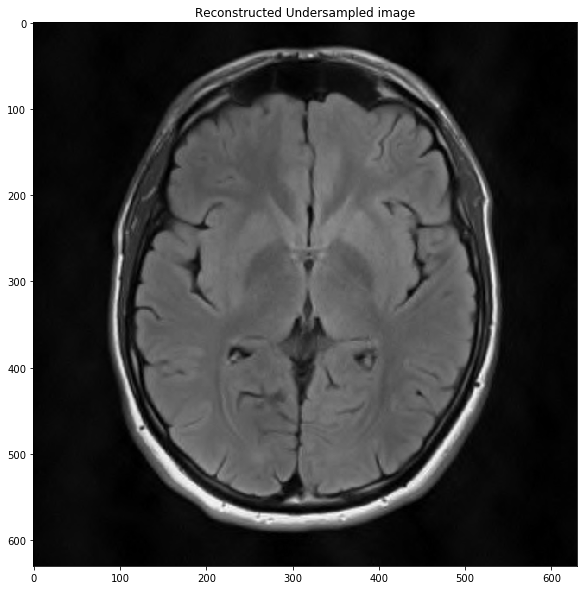

In [12]:
#call the functon
ix_1= fista(center*randomgauss_,randomgauss_,2,1,Nit=300)
#plot the result
plt.figure(figsize=(10,10), constrained_layout=False)
plt.imshow(abs(ix_1), "gray"), plt.title("Reconstructed Undersampled image")
plt.show()

If the original image is known and one wishes to test the algorithms the following functions can be used _ista\_errors_ , _fista\_errors_ , _conj\_grad\_errors_ , _mfista\_errors_ , _watv\_errors_ .They return the reconstructed image, an error term calculated as the l1 norm between the original image and reconstructed image in wavelet space for each step and with the exception of _watv\_errors_ the values of the objective function in each step. An example will be given again using the fista algorithm.

In [38]:
def error(x_wavelet,image_wavelet):
    return np.linalg.norm((image_wavelet-x_wavelet[0]).ravel(),ord=1)

def ista_errors(y,pattern,image,regpar,alpha,Nit):
    """
    Input: 
    y - observed signal
    regpar - regrularization parameter
    alpha - need alpha >= max(eig(H'*H))
    Nit - number of iterations
    pattern - sampling pattern used
    image - the original image that the algorithm aims to reconstruct
    Output:
    x - result of deconvolution
    f_obj - objective function
    error - the l1 norm of the difference of the original image and the reconstruction in waveletspace
    """
    x= adjoint_fourier(y) #initialize x
    #treshold parameter
    T = regpar/(2*alpha)
    #initialize error and array containing the values of the objective function 
    arr_img =  wavelet(image)[0]
    errors=[error(wavelet(x)[0],arr_img)]
    f_obj=[objective(x,y,pattern)]
    for k in range(Nit):
        #Axk in (3)  
        Hx = pattern*fourier(x)
        #computation of the wavelet transform of x used for the tresholding
        arr,coeff_slices = wavelet(x)
        #2tkAT (Axk − b) in (3)
        norm2 = adjoint_fourier(y-Hx)/alpha 
        #computation of the wavelet transform of 2tkAT (Axk − b) in (3) in order to do the tresholding in wavelet space
        arr_norm2 = wavelet(norm2)[0]
        #do the tresholding in wavelet space
        x_wavelet = pywt.threshold(arr+arr_norm2, T, mode='soft')
        #calculate error
        errors.append(error(x_wavelet,arr_img))
        #return to image space
        x=inverse_wavelet(x_wavelet,coeff_slices)
        #calculate objective function
        f_obj.append(objective(x,y,pattern))
    return abs(x) ,f_obj,errors

def fista_errors(obs,pattern,image,regpar=1,lipshitz=1,Nit=100):
    """
    Input: 
    obs - observed signal
    Nit - number of iterations
    pattern - sampling pattern used
    regpar=1 -regularization parameter
    lipshitz=1 -lipshitz konstant
    
    Output:
    x - result of deconvolution
    f_obj - objective function
    error - the l1 norm of the difference of the original image and the reconstruction in waveletspace
    """
    #initialize x0 to be the fourier transform of the observed signal
    x_1= adjoint_fourier(obs) #initialize x
    #initialize y1=x0
    y = np.copy(x_1)
    #initalize t=1
    t=1
    #initialize error and array containing the values of the objective function 
    arr_img =  wavelet(image)[0]
    errors=[error(wavelet(x_1)[0],arr_img)]
    f_obj=[objective(x_1,obs,pattern)]
    for k in range(Nit):
        x_0= np.copy(x_1)
        t_old=t
        #the step calculating xk+1 is analog to the step in the normal ista with the only difference that x is exchanged for y (11)
        Hy = pattern*fourier(y) #Ay
        #wavelet transform of y used in the tresholding
        arr,coeff_slices= wavelet(y)
        # in (9) this part represents 1/L ∇f(yk) which referce to 2tkAT (Axk − b) in (3)
        norm2 = adjoint_fourier(obs-Hy)/lipshitz
        #the wavelet transform of 1/L ∇f(yk), computed in order to do the tresholding in wavelet space
        arr_norm2 = wavelet(norm2)[0]
        # proxtk (g) according to (9) which as stated in the paragraf below (7) is equivalent for g(x) := λ||x||1 to  soft tresholding
        y_wavelet = pywt.threshold(arr+arr_norm2, regpar/lipshitz, mode='soft')
        #calculate error
        errors.append(error(y_wavelet,arr_img))
        #return to image space
        x_1 = inverse_wavelet(y_wavelet,coeff_slices)
        #calculate objective function
        f_obj.append(objective(x_1,obs,pattern))
        #step (10) compute tk+1
        t=(1+(1+4*(t**2))**0.5)/2
        #step (11) compute yk+1
        y=x_1+(((t_old-1)/t)*(x_1-x_0))
    return  abs(x_1),f_obj,errors

def con_grad_errors(data,pattern,image,lamb,TolGrad = 10**(-4), MaxIter = 100,alpha=0.05, beta = 0.6):
    """
    Input:
    data - k space measurments
    pattern - sampling pattern
    lamb - a data consistency tuning constant
    image - image to be reconstructed
    Optional Input:
    TolGrad - stopping criteria by gradient magnitude, deafult TolGrad = 10^-4
    MaxIter - stopping criteria by number of iterations, deafult MaxIter = 100
    alpha, beta - line search parameters, defaults: alpha=0.05, beta = 0.6
    
    OUTPUTS:
    m - numerical aproximation of the original image
    f_obj -objective function
    error -the deviation from the original image
    """
    # Initialization
    k = 0
    m = np.zeros(data.shape)
    g_0=delta_fm(m,data,lamb,pattern)
    delta_m=np.copy(-g_0)
    #initialize error and array containing the values of the objective function 
    arr_img =  wavelet(image)[0]
    errors=[error(wavelet(m)[0],arr_img)]
    f_obj=[objective(m,data,pattern)]
    while (np.linalg.norm(g_0)>TolGrad) and (k<MaxIter):
        t=1
        term2_last=np.linalg.norm(np.real(np.transpose(np.conjugate(g_0))@delta_m),ord=1)
        term2_first=f_cost(m,data,lamb,pattern)
        ct = 0
        while f_cost(m+(t*delta_m),data,lamb,pattern) > (term2_first+ alpha *t*term2_last):
            t=beta*t
            ct=ct+1
            if ct>5:
                break
        m=m+(t*delta_m)
        #compute error function
        errors.append(error(wavelet(m)[0],arr_img))
        #compute objective function
        f_obj.append(objective(m,data,pattern))
        g_old=np.copy(g_0)
        g_0=delta_fm(m,data,lamb,pattern)
        gama = (np.linalg.norm(g_0)**2)/(np.linalg.norm(g_old)**2)
        delta_m = -g_0+gama*delta_m
        k=k+1
    return abs(m),f_obj,errors

def mfista_errors(obs,pattern,image,regpar=1,lipshitz=1,Nit=100):

    """
    Input: 
    obs - observed signal
    Nit - number of iterations(default is 100)
    pattern - sampling pattern used
    image - image to be reconstructed
    regpar=1 -regularization parameter
    lipshitz=1 -lipshitz konstant
    
    
    Output:
    x - result of deconvolution
    f_obj - objective function
    error - the l1 norm of the difference of the original image and the reconstruction in waveletspace
    """
    #initialize x0 to be the fourier transform of the observed signal
    x_1= adjoint_fourier(obs) #initialize x
    #initialize y1=x0
    y = np.copy(x_1)
    #initalize t=1
    t=1
    #initialize error and array containing the values of the objective function 
    arr_img =  wavelet(image)[0]
    errors=[error(wavelet(x_1)[0],arr_img)]
    f_obj=[objective(x_1,obs,pattern)]
    for k in range(Nit):
        x_0= np.copy(x_1)
        t_old=t
        #the step calculating xk+1 is analog to the step in the normal ista with the only difference that x is exchanged for y (11)
        Hy = pattern*fourier(y) #Ay
        #wavelet transform of y used in the tresholding
        arr,coeff_slices= wavelet(y)
        #Objecive function
        objective_f = objective (x_1,obs,pattern)
        # in (9) this part represents 1/L ∇f(yk) which referce to 2tkAT (Axk − b) in (3)
        norm2 = adjoint_fourier(obs-Hy)/lipshitz
        #the wavelet transform of 1/L ∇f(yk), computed in order to do the tresholding in wavelet space
        arr_norm2 = wavelet(norm2)[0]
        # proxtk (g) according to (9) which as stated in the paragraf below (7) is equivalent for g(x) := λ||x||1 to  soft tresholding
        y_wavelet = pywt.threshold(arr+arr_norm2, regpar/lipshitz, mode='soft')
        #return to image space
        zk = inverse_wavelet(y_wavelet,coeff_slices)
        #Choose between fista or ista
        t=(1+(1+4*(t**2))**0.5)/2
        if objective_f> objective (zk,obs,pattern):
            x_1= np.copy(zk)
            y=x_1+(((t_old-1)/t)*(x_1-x_0))
        else:
            y=x_1+((t_old/t)*(zk-x_0))
        errors.append(error(wavelet(x_1)[0],arr_img))
        f_obj.append(objective_f)
    return abs(x_1),f_obj,errors


def WATV_errors(obs,image,regpar_wavelet=1,regpar_tv=1,regpar=1,Nit=100):
    """
    Input: 
    obs - observed signal
    Nit - number of iterations(default is 100)
    regpar=1 - regularization parameter
    regpar_tv=1 - regularization parameter for tv denoising
    regpar_wavelet=1 - regularization parameter for tresholding
    image - image to be reconstructed
    Output:
    result of deconvolution
    error - the l1 norm of the difference of the original image and the reconstruction in waveletspace
    """
    #initialize arr to be the wavelet transform of the inverse fourier transform of the observed signal
    image_space= adjoint_fourier(obs) 
    wavelet_signal,coeffitient_slices= wavelet(image_space)
    u=np.copy(wavelet_signal)
    d=0*wavelet_signal
    #initialize list of errors
    arr_img =  wavelet(image)[0]
    errors=[error(wavelet_signal,arr_img)]

    for i in range(Nit):
        p=(wavelet_signal+(regpar*(u-d)))/(regpar+1)
        w = pywt.threshold(p, regpar_wavelet/(regpar+1), mode='hard')
        errors.append(error(w,arr_img))
        v=d+w
        #return v to image space
        image_v = abs(inverse_wavelet(v,coeffitient_slices))
        #calculate the wavelet transform of the tv denoised image of v - image of v
        wavelet_tv_reg=wavelet(denoise_tv_chambolle(image_v,weight=(regpar_tv/regpar))-image_v)[0]
        u=v+wavelet_tv_reg
        d=d-(u-w)
    return abs(inverse_wavelet(w,coeffitient_slices)), errors

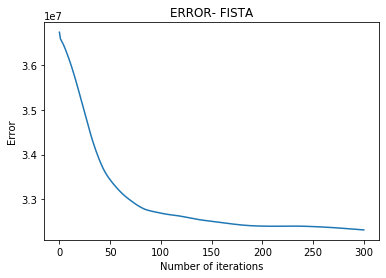

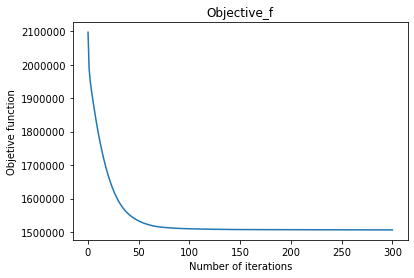

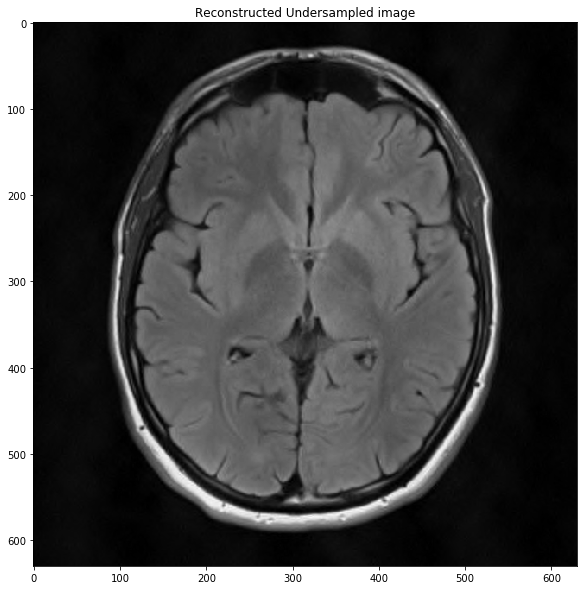

In [29]:
fx_1,fJ_1,ferrors1,= fista_errors(center*randomgauss_,randomgauss_,img,regpar=0.5,Nit=300)
plt.plot(ferrors1), plt.title("ERROR- FISTA")
plt.ylabel('Error')
plt.xlabel('Number of iterations')
plt.show()
plt.plot(fJ_1), plt.title("Objective_f")
plt.ylabel('Objetive function')
plt.xlabel('Number of iterations')
plt.show()
plt.figure(figsize=(10,10), constrained_layout=False)
plt.imshow(fx_1, "gray"), plt.title("Reconstructed Undersampled image")
plt.show()